In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleDict
from torch_geometric.data import DataLoader
from torch_geometric.nn import HeteroConv, global_mean_pool
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
import os
import glob

GRAPH_FOLDER = "graph/"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [2]:
import json

with open("data/labels.json") as f:
    labels_dict = json.load(f)

graphs, labels = [], []

for file in glob.glob(os.path.join(GRAPH_FOLDER, "*.pt")):
    graph = torch.load(file, weights_only=False)
    graph = ToUndirected()(graph)
    graph['label'] = torch.tensor([labels_dict[os.path.basename(file)]], dtype=torch.float)
    graphs.append(graph)
    labels.append(labels_dict[os.path.basename(file)])


In [3]:
# 3. Split into train/test
from sklearn.model_selection import train_test_split

train_graphs, test_graphs = train_test_split(graphs, test_size=0.4, stratify=labels, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=2)

/opt/homebrew/anaconda3/envs/cs485/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
from torch.nn import ReLU, Dropout
from torch_geometric.nn import SAGEConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), 32)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.lin = Linear(32, 1)

    def forward(self, x_dict, edge_index_dict, batch_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        pooled = []
        for node_type in x_dict:
            pooled.append(global_mean_pool(x_dict[node_type], batch_dict[node_type]))
        out = torch.stack(pooled).sum(dim=0)  # sum all node embeddings
        return self.lin(out).view(-1)

In [5]:
# Instantiate model
metadata = train_graphs[0].metadata()
model = HeteroGNN(metadata).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Train/test + loss functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict, data.batch_dict)
        loss = criterion(out, data['label'].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = torch.sigmoid(model(data.x_dict, data.edge_index_dict, data.batch_dict))
            pred = (out > 0.5).float()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data['label'].cpu().numpy())
    
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return accuracy, precision, recall, f1


In [9]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy', 'precision', 'recall', 'f1'])

# training loop
for epoch in range(1, 201):
    loss = train()
    accuracy, precision, recall, f1 = test(test_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    # Append logs to the dataframe
    new_row = {'epoch': epoch, 'loss': f"{loss}", 'accuracy': f"{accuracy}", 
               'precision': f"{precision}", 'recall': f"{recall}", 'f1': f"{f1}"}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    if loss < 0.01:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        break

# Save the dataframe as csv
df.to_csv("model/hetero_gnn_training_results.csv", index=False)

# Save the model
torch.save(model.state_dict(), f"model/hetero_gnn_epoch_{epoch}.pth")

Epoch 10, Loss: 706.3158, Test Acc: 0.8571, Precision: 0.7500, Recall: 1.0000, F1: 0.8571
Epoch 20, Loss: 333.7846, Test Acc: 0.8571, Precision: 0.7500, Recall: 1.0000, F1: 0.8571
Epoch 30, Loss: 372.1268, Test Acc: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


/opt/homebrew/anaconda3/envs/cs485/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/cs485/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/cs485/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 40, Loss: 174.8103, Test Acc: 0.5714, Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Epoch 43, Loss: 0.0000, Test Acc: 0.8571, Precision: 1.0000, Recall: 0.6667, F1: 0.8000


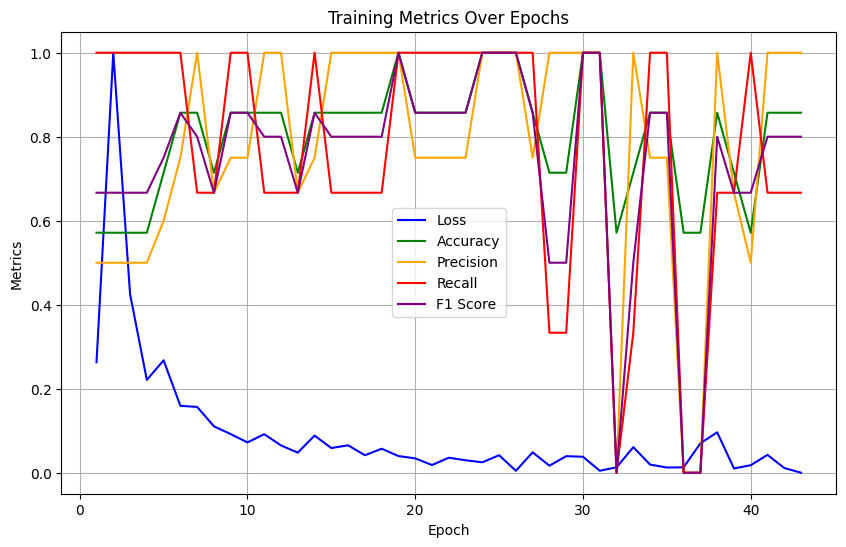

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("model/hetero_gnn_training_results.csv")

# Plot the metrics
df['loss'] = (df['loss'] - df['loss'].min()) / (df['loss'].max() - df['loss'].min())
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['loss'], label='Loss', color='blue')
plt.plot(df['epoch'], df['accuracy'], label='Accuracy', color='green')
plt.plot(df['epoch'], df['precision'], label='Precision', color='orange')
plt.plot(df['epoch'], df['recall'], label='Recall', color='red')
plt.plot(df['epoch'], df['f1'], label='F1 Score', color='purple')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()